In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from b_funks import load, plot, csystem
from b_funks.helpers import weighted_moving_average,  isolate_constant_conditions, make_figpath
from cbsyst import Csys
from scipy import stats
import uncertainties as un
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# raw = load.raw_b_data('data/B_data_raw.csv', 'Orbulina')
raw = load.raw_b_data('data/B_data_raw.csv')
raw = raw.loc[:, [c for c in raw.columns if 'Unnamed' not in c]]
raw.columns = pd.MultiIndex.from_product([['Measured'], raw.columns])

# raw = raw.loc[raw.Measured.who == 'This Study']

In [6]:
raw = csystem.calc_pitzer_Csys(raw)
raw = csystem.calc_MyAMI_Csys(raw)
raw = csystem.mean_Csys(raw)

Calculating Experimental T Corrections: 100%|██████████| 129/129 [00:01<00:00, 121.05it/s]


In [7]:
raw.loc[:, ('csys_mid', 'Omega')] = raw.loc[:, ('csys_mid', 'CO3')] * 1e-6 * raw.loc[:, ('Measured', '[Ca]sw')] * 1e-3 / raw.loc[:, ('csys_mid', 'KspC')]

## Estimate Uncertainties in Data

In [8]:
kh = raw.loc[raw.Measured.who == 'This Study']

In [9]:
kh.loc[:, ('Measured', 'B/Caf_std')] = kh.loc[:, ('Measured', 'B/Caf_err')] * 0.5 * kh.loc[:, ('Measured', 'numberforams')]**0.5
kh.loc[:, ('Measured', 'B/Caf_rsd')] = kh.loc[:, ('Measured', 'B/Caf_std')] / kh.loc[:, ('Measured', 'B/Caf')]

/tmp/ipykernel_19470/3410048399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kh.loc[:, ('Measured', 'B/Caf_std')] = kh.loc[:, ('Measured', 'B/Caf_err')] * 0.5 * kh.loc[:, ('Measured', 'numberforams')]**0.5
/tmp/ipykernel_19470/3410048399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kh.loc[:, ('Measured', 'B/Caf_rsd')] = kh.loc[:, ('Measured', 'B/Caf_std')] / kh.loc[:, ('Measured', 'B/Caf')]


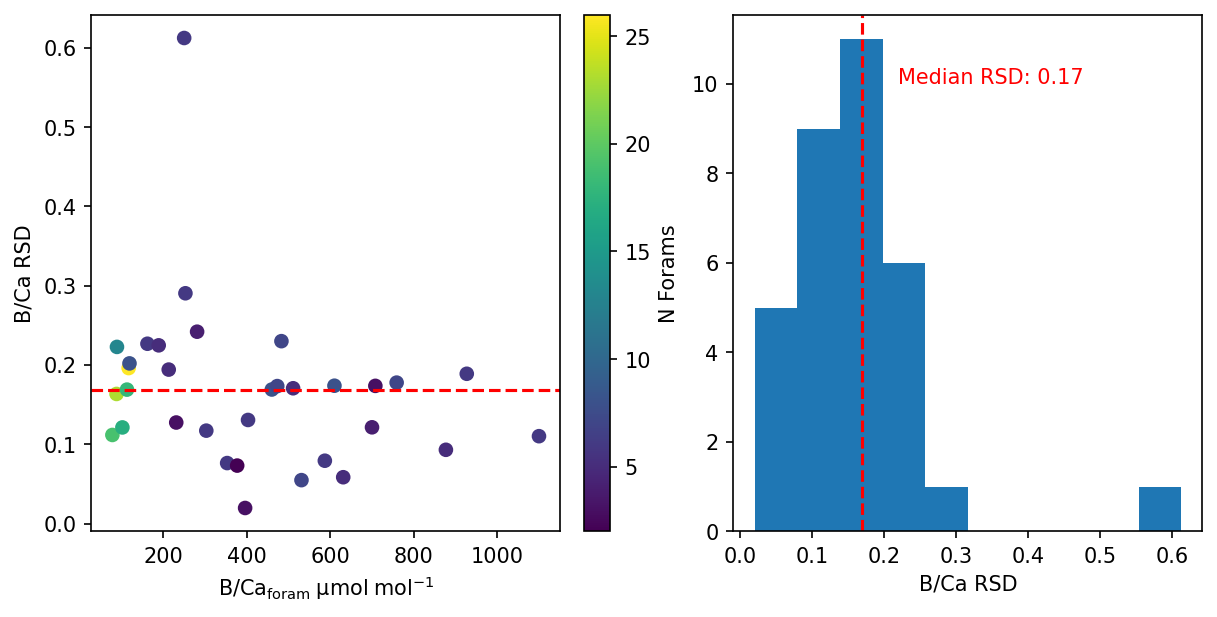

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 4], constrained_layout=True)

ma = ax1.scatter(kh.loc[:, ('Measured', 'B/Caf')], kh.loc[:, ('Measured', 'B/Caf_rsd')], c=kh.loc[:, ('Measured', 'numberforams')])
fig.colorbar(ma, ax=ax1, label='N Forams')

ax2.hist(kh.loc[:, ('Measured', 'B/Caf_rsd')])

RSD_BCa = kh.loc[:, ('Measured', 'B/Caf_rsd')].median()

ax2.axvline(RSD_BCa, color='r', ls='dashed')
ax2.text(RSD_BCa + 0.05, 10, f'Median RSD: {RSD_BCa:.2f}', color='r')

ax1.set_xlim(ax1.get_xlim())

xn = np.linspace(ax1.get_xlim(), 2)
ax1.axhline(RSD_BCa, color='r', ls='dashed')

ax1.set_ylabel('B/Ca RSD')
ax1.set_xlabel('$B/Ca_{foram}~\mu mol~ mol^{-1}$')

ax2.set_xlabel('B/Ca RSD')

fig.savefig(make_figpath('S1_ForamRSD.pdf'))

In [11]:
RSD_BCa

0.16909075202287008

In [12]:
# estimate std from RSD and measured B/Ca
raw.loc[:, ('Uncertainties', 'estimated_std')] = raw.loc[:, ('Measured', 'B/Caf')] * RSD_BCa

# get reported uncertainty
raw.loc[:, ('Uncertainties', 'reported_std')] = raw.loc[:, ('Measured', 'B/Caf_err')]
# convert to std
ind = raw.Measured.loc[:, 'err_type'] == '2x longterm RSD of analysis method'
raw.loc[~ind, ('Uncertainties', 'reported_std')] *= 0.5 * raw.loc[~ind, ('Measured', 'numberforams')]**0.5  # values in table are 2xSE calculated from multiple analysed specimens
raw.loc[ind, ('Uncertainties', 'reported_std')] /= 2  # values in table are 2xSTD *calculated* from long-term RSD

# Henehan special case
ind = raw.Measured.loc[:, 'err_type'] == 'Uncertainty on culture B/Ca is estimated as a quadratic addition of 5% errors in culture and control measurements'
raw.loc[ind, ('Uncertainties', 'reported_std')] = raw.loc[ind, ('Measured', 'B/Caf_err')]

# where estimated uncertainty is larger than reported, use estimated
raw.loc[:, ('Uncertainties', 'std')] = raw.loc[:, ('Uncertainties', 'reported_std')]
ind = raw.loc[:, ('Uncertainties', 'reported_std')] < raw.loc[:, ('Uncertainties', 'estimated_std')]
raw.loc[ind, ('Uncertainties', 'std')] = raw.loc[:, ('Uncertainties', 'estimated_std')]

# calculate SE and CI95
raw.loc[:, ('Uncertainties', 'se')] = raw.loc[:, ('Uncertainties', 'std')] / raw.loc[:, ('Measured', 'numberforams')]**0.5
raw.loc[:, ('Uncertainties', 'ci95')] = raw.loc[:, ('Uncertainties', 'se')] * stats.t.interval(0.95, df=raw.loc[:, ('Measured', 'numberforams')] - 1)[-1]
raw.loc[:, ('Uncertainties', 'ci68')] = raw.loc[:, ('Uncertainties', 'se')] * stats.t.interval(0.68, df=raw.loc[:, ('Measured', 'numberforams')] - 1)[-1]

In [13]:
raw.to_csv('data/B_compiled.csv')